# Predicting Health Outcomes of Horses

### Suppressing Warnings

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Importing The Necessary Libraries

In [2]:
# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Scaling
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modelling and Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# Model funcs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Loading And Exploring Data

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [4]:
# Explore the data to understand its structure, missing values, and feature distribution
print(train_data.info())
print(train_data.describe())
print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

### Outcome Distribution Visualization

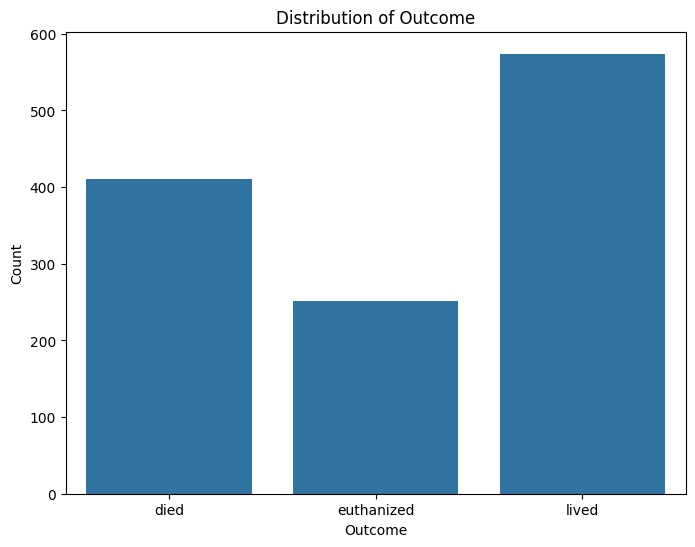

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='outcome')
plt.title('Distribution of Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

### Missing Value Heatmap - Initial

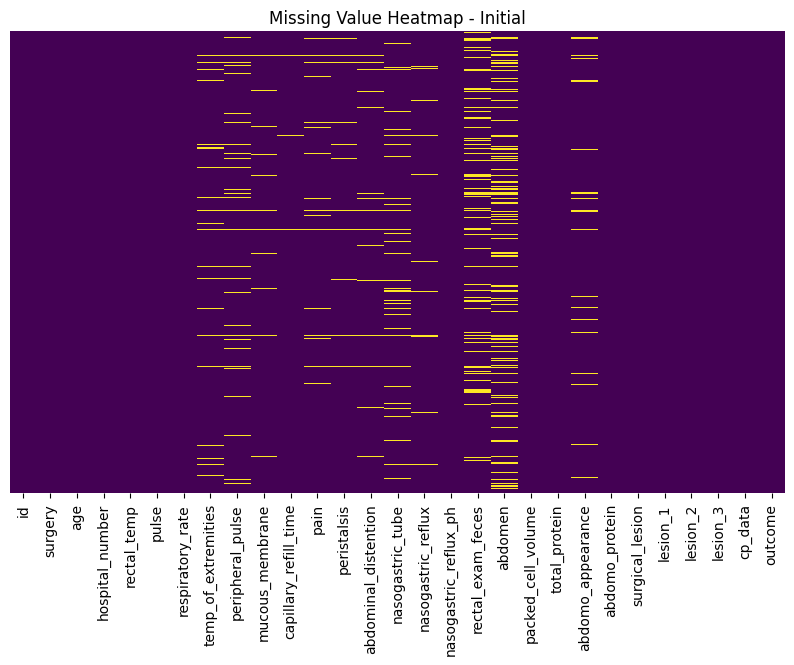

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Value Heatmap - Initial')
plt.show()

### Handle Missing Values

In [7]:
# Fill missing values for numeric columns in train_data
numerical_cols = train_data.select_dtypes(include=['float64']).columns
train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].mean())

# Fill missing values for numeric columns in test_data
test_numerical_cols = test_data.select_dtypes(include=['float64']).columns
test_data[test_numerical_cols] = test_data[test_numerical_cols].fillna(test_data[test_numerical_cols].mean())


### Encoding Categorical Variables
Using One-hot Encoding of the 'sklearn' library to encode categorical variables.

In [8]:
# Extract the 'outcome' column before one-hot encoding in the training data
outcome_column = train_data['outcome']

# Drop the 'outcome' column from the training data
train_data = train_data.drop(columns=['outcome'])

# One-hot encode categorical columns in train_data
categorical_cols = train_data.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_data_encoded = encoder.fit_transform(train_data[categorical_cols])

# Get feature names after one-hot encoding
feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# Convert the encoded data to a DataFrame with proper column names
train_data_encoded_df = pd.DataFrame(train_data_encoded, columns=feature_names)

# Concatenate the encoded DataFrame with the original DataFrame
train_data = pd.concat([train_data.drop(columns=categorical_cols), train_data_encoded_df], axis=1)

In [9]:
# One-hot encode categorical columns in test_data
test_categorical_cols = test_data.select_dtypes(include=['object']).columns
test_data_encoded = encoder.transform(test_data[test_categorical_cols])

# Get feature names after one-hot encoding for test_data
test_feature_names = encoder.get_feature_names_out(input_features=test_categorical_cols)

# Convert the encoded test data to a DataFrame with proper column names
test_data_encoded_df = pd.DataFrame(test_data_encoded, columns=test_feature_names)

# Concatenate the encoded test DataFrame with the original test DataFrame
test_data = pd.concat([test_data.drop(columns=test_categorical_cols), test_data_encoded_df], axis=1)

In [10]:
# Add the 'outcome' column back to the training data
train_data['outcome'] = outcome_column

In [11]:
# Standardize numerical features
scaler = StandardScaler()
numerical_cols = train_data.select_dtypes(include=['float64']).columns
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

### Missing Value Heatmap - Final

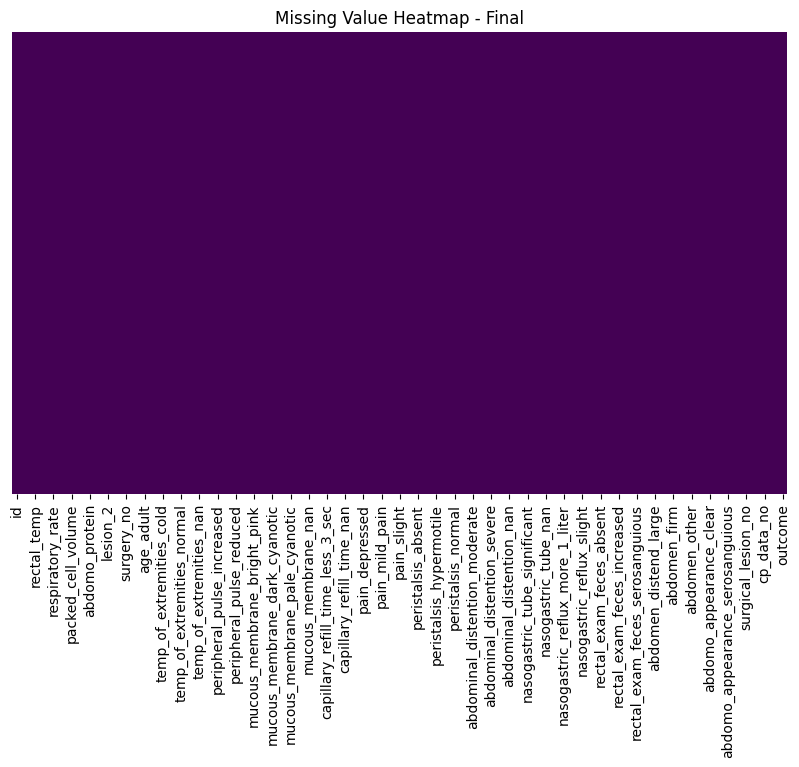

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Value Heatmap - Final')
plt.show()

### Splitting Data for Model Training

In [13]:
X = train_data.drop(columns=['outcome', 'id'])
y = train_data['outcome']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training And Evaluating Models

### Initializing Models

In [14]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

### Training and Evaluating Models

In [15]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    print("\n")

Model: Random Forest
Accuracy: 0.73
              precision    recall  f1-score   support

        died       0.62      0.78      0.69        72
  euthanized       0.77      0.61      0.68        54
       lived       0.80      0.75      0.77       121

    accuracy                           0.73       247
   macro avg       0.73      0.71      0.72       247
weighted avg       0.74      0.73      0.73       247

[[56  2 14]
 [12 33  9]
 [22  8 91]]


Model: Logistic Regression
Accuracy: 0.43
              precision    recall  f1-score   support

        died       0.29      0.15      0.20        72
  euthanized       0.00      0.00      0.00        54
       lived       0.45      0.79      0.58       121

    accuracy                           0.43       247
   macro avg       0.25      0.31      0.26       247
weighted avg       0.31      0.43      0.34       247

[[11  0 61]
 [ 1  0 53]
 [26  0 95]]


Model: SVC
Accuracy: 0.49
              precision    recall  f1-score   support

 

## Hyperparameter Tuning & Training

### Parameter Grid

In [16]:
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 200, 300]
    },
    # Since the time complexity of SVC is O(n^3)
    # 'SVC': {
    #     'C': [0.001, 0.01, 0.1, 1, 10],
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'degree': [2, 3, 4],
    #     'gamma': ['scale', 'auto']
    # },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2, 3]
    }
}

### Tuning & Training

Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy for Random Forest: 0.7095216120596831


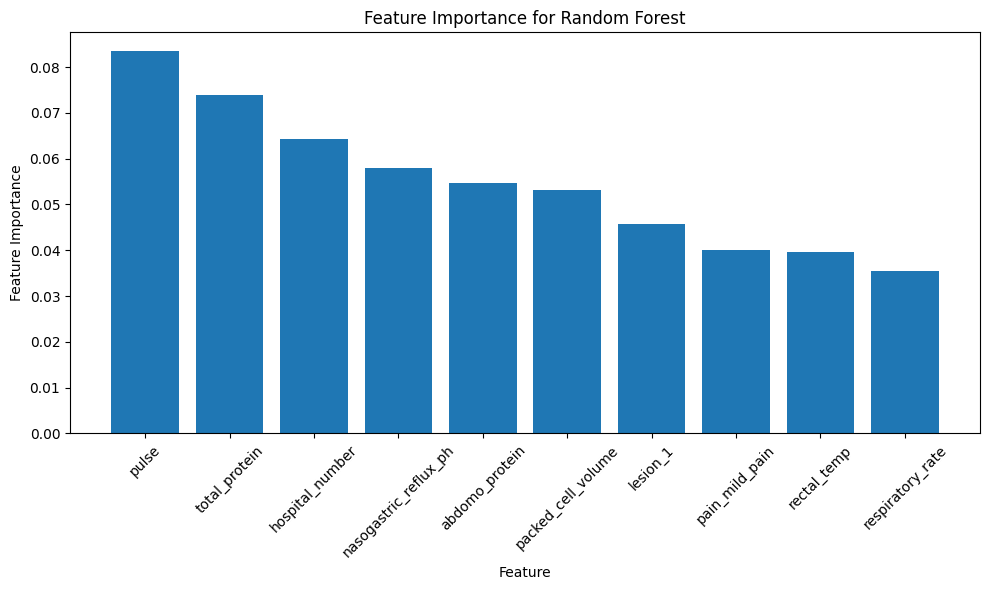

Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best Accuracy for Logistic Regression: 0.40590165615546325
Best Parameters for Decision Tree: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Accuracy for Decision Tree: 0.624473157975696


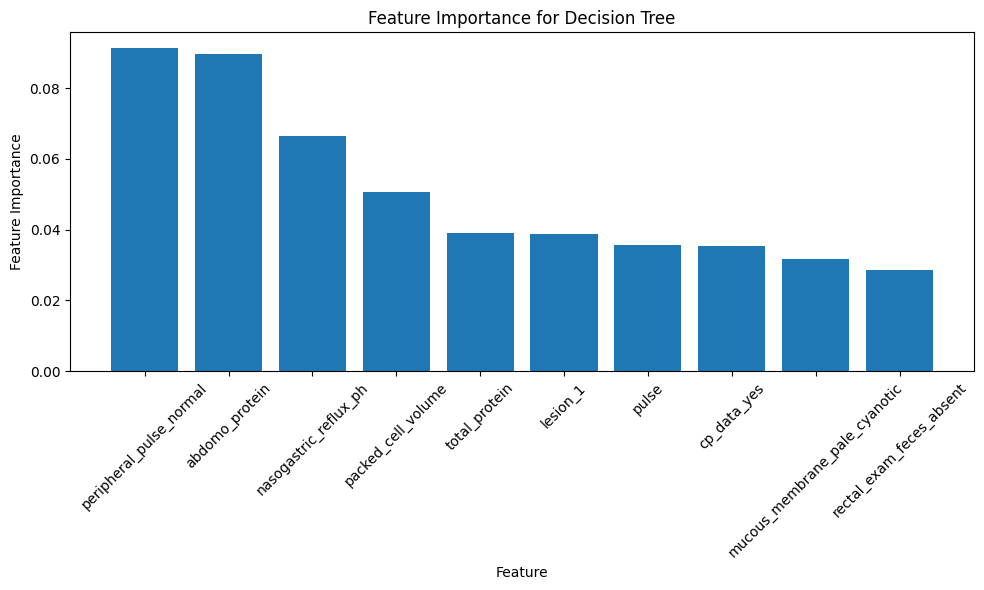

Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Best Accuracy for Gradient Boosting: 0.7136030354304466


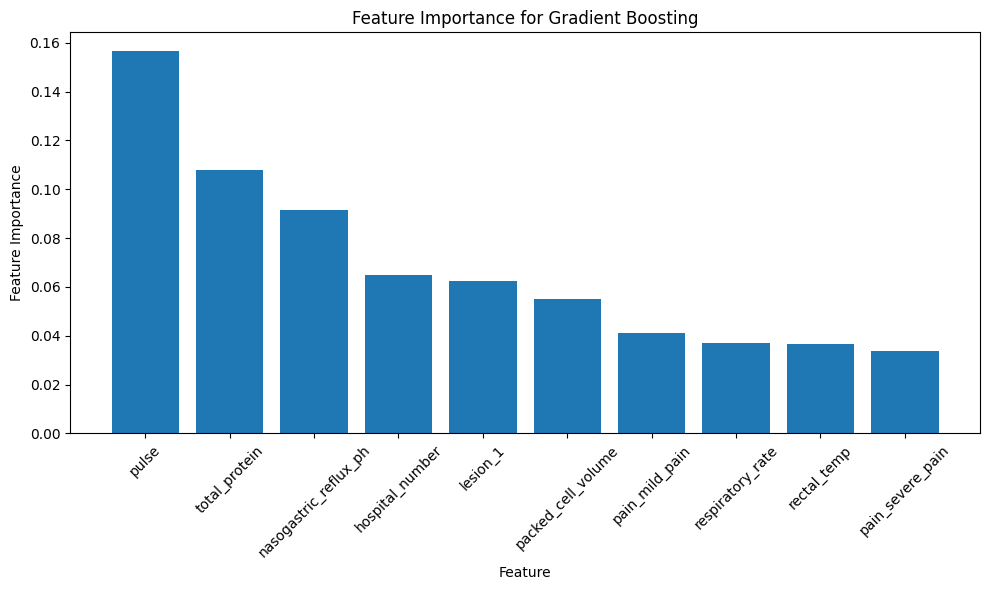

In [17]:
# Loop through models
for model_name, model in models.items():
    # Skipping SVC due to O(n^3) time complexity and unusually high training time
    if model_name == 'SVC':
        continue

    # Get the corresponding parameter grid
    param_grid = param_grids[model_name]
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               scoring='accuracy', cv=5, n_jobs=-1)
    
    # Fit the GridSearchCV to the data
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and the corresponding accuracy
    print(f"Best Parameters for {model_name}:", grid_search.best_params_)
    print(f"Best Accuracy for {model_name}:", grid_search.best_score_)
    
    # Select the best-performing model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Train the selected model on the entire training data
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test data after excluding 'id' column
    y_pred = best_model.predict(test_data.drop(columns=['id']))
    
    # Create a submission DataFrame and save it to a CSV file
    submission_df = pd.DataFrame({'id': test_data['id'], 'outcome': y_pred})
    submission_df.to_csv(f'submission_{model_name}.csv', index=False)
    
    # Visualize feature importances for models that support it
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        feature_names = X_train.columns

        # Sort feature importances in descending order
        sorted_idx = feature_importances.argsort()[::-1]
        
        # Top 10 features
        top_features = sorted_idx[:10]
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(range(10), feature_importances[top_features], align='center')
        plt.xticks(range(10), feature_names[top_features], rotation=45)
        plt.xlabel('Feature')
        plt.ylabel('Feature Importance')
        plt.title(f'Feature Importance for {model_name}')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{model_name}.png')
        plt.show()